# Nuclear ANN 

### Load and preprocess data

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/Ml/getData/fuelWeatherCombined.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
nuclear_data = data[['BeginDate', 'Nuclear','Previous_Day','Previous_Year','Previous_2Day']].copy()


/var/folders/lp/l5v0z5894r912dc6qp90m2j00000gn/T/ipykernel_16807/1136792515.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/dltc2020/Documents/Senior-project/Ml/getData/fuelWeatherCombined.csv')


In [22]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [23]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [24]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [25]:
# Large computation 
data['Previous_Year_Nuclear'] = data.apply(get_previous_year_Wind, axis=1, reference_df=nuclear_data)

In [26]:
cutoff_date = pd.to_datetime("2024-11-30").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Nuclear','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [27]:


usable_data['Previous_Day_Nuclear'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Nuclear'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [28]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Year'] = usable_data['BeginDate'].dt.year
usable_data['Month'] = usable_data['BeginDate'].dt.month
usable_data['Day'] = usable_data['BeginDate'].dt.day
features = usable_data[['Month','Day','Previous_2Day_Nuclear','Sum','Hour_of_Day']]


# Useless Features , , 
target = usable_data['Nuclear']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (1294, 5)
Target shape:  (1294,)


In [29]:
from tensorflow.keras import regularizers
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, y_train, epochs=450, validation_split=0.15, batch_size=128)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/450


/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3357.7725 - val_loss: 3357.7637
Epoch 2/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3357.1108 - val_loss: 3357.0920
Epoch 3/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3356.4619 - val_loss: 3356.0466
Epoch 4/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3355.2383 - val_loss: 3354.3713
Epoch 5/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3353.1301 - val_loss: 3351.7329
Epoch 6/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3349.9648 - val_loss: 3347.6985
Epoch 7/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3345.3135 - val_loss: 3341.7131
Epoch 8/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3338.6162 - val_loss: 3333.0408
Epoch 9/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3328.5278 - val_loss: 3320.7292
Epoch 10/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3314.4456 - val_loss: 3303.6252
Epoch 11/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3294.5181 - val_loss: 3280.3264
Epoch 12/450
7/7 ━━━━━━━━━━━━━

### Analysis

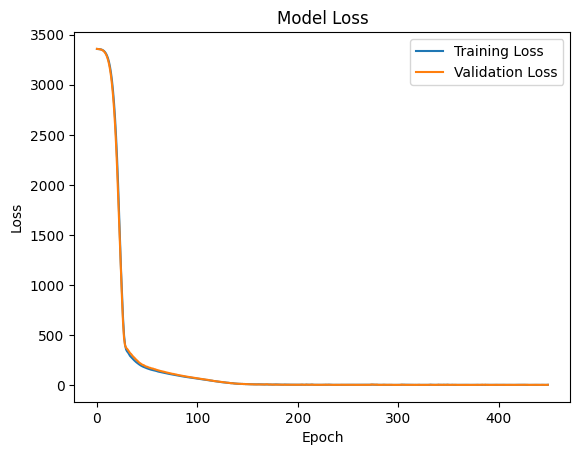

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [31]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Predicted Solar Energy Ouput: [3354.749267578125, 3355.24169921875, 3354.74755859375, 3355.71533203125, 3355.751220703125, 3354.27783203125, 3356.760986328125, 3357.3056640625, 3354.89453125, 3356.69921875, 3358.33203125, 3355.39404296875, 3354.28466796875, 3354.791259765625, 3353.812744140625, 3376.4658203125, 3354.7265625, 3354.0703125, 3356.09423828125, 3355.56005859375]
Actual Solar Energy Output: [3357. 3358. 3359. 3356. 3359. 3359. 3354. 3359. 3358. 3358. 3361. 3359.
 3358. 3352. 3353. 3357. 3357. 3359. 3356. 3359.]


In [32]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 3.2177376176399615
Mean Squared Error (MSE): 15.653488868912214
Root Mean Squared Error (RMSE): 3.956449022660625
Percent Error (PERR): 0.0009582314822440185


### Save model

In [33]:
model.save('NuclearModel.h5')